In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import utils
from environment import RULEnvironment

from stable_baselines3 import DQN 
from stable_baselines3.common.env_checker import check_env

### Load and preprocess train data

In [2]:
# Config
figsize = (9, 3)

In [3]:
data_path = "./data"
data = utils.load_data(data_path)
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [4]:
# Last column is the RUL (Label)
dt_in = list(data.columns[3:-1])
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


In [5]:
# Check for null-values
data[dt_in].isnull().any().any()

# No null values

False

In [6]:
# Standardize all the daa-columns
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-1.041426,-1.115415,0.345954,1.079181,1.046623,1.037987,1.024530,...,0.345198,0.616063,-0.845214,0.963586,1.009019,0.801652,0.345954,1.121959,1.119490,191
1,train_FD001,1,2,-1.041268,-1.115143,0.345954,1.079181,1.054391,1.055926,1.043166,...,0.345648,0.527627,-0.828849,0.963586,1.009019,0.801652,0.345954,1.116827,1.120146,190
2,train_FD001,1,3,-1.041644,-1.113512,0.345954,1.079181,1.059100,1.023517,1.050943,...,0.345288,0.549209,-0.847476,0.963586,0.944547,0.801652,0.345954,1.112550,1.108828,189
3,train_FD001,1,4,-1.041341,-1.114327,0.345954,1.079181,1.059100,0.979514,1.033848,...,0.345738,0.556651,-0.913470,0.963586,1.009019,0.801652,0.345954,1.106563,1.113061,188
4,train_FD001,1,5,-1.041498,-1.114871,0.345954,1.079181,1.059570,0.980022,1.065763,...,0.345378,0.556279,-0.832042,0.963586,1.041254,0.801652,0.345954,1.108273,1.117409,187


In [7]:
data_sv_dict = utils.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


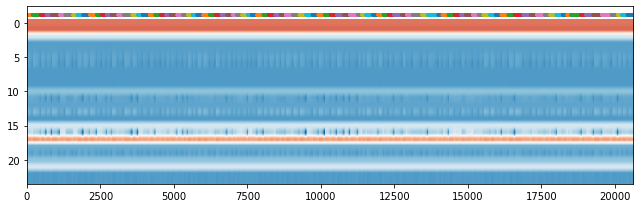

In [8]:
tmp = data_sv_dict['train_FD001']
utils.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

### Train environment

In [9]:
env = RULEnvironment(data_sv, dt_in)

/Users/andreastettejessen/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [10]:
states = env.observation_space.shape
actions = env.action_space.n
states

(24,)

In [11]:
#check_env(env)

### Test environment

In [12]:
data_path = "./data"
data_test = utils.load_data(data_path, test=True)
dt_in_test = list(data_test.columns[3:-1])
data_test.describe()

# 707 machines
# Max amount of cycles: 486

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,...,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000
mean,372.662478,95.406589,17.243810,0.410887,95.748591,485.791314,597.153354,1464.738375,1257.240382,9.887805,...,2349.811235,8084.687648,9.046593,0.025039,360.088096,2273.841797,98.398282,25.949868,15.570426,94.406589
std,201.744654,74.311486,16.530141,0.368078,12.328151,30.426804,42.430629,117.856835,135.728855,4.265536,...,110.890533,78.956087,0.748390,0.005000,30.932463,142.218102,4.644631,11.701010,7.020590,74.311486
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.410000,1240.940000,1024.900000,3.910000,...,2027.740000,7849.800000,8.198000,0.020000,302.000000,1915.000000,84.930000,10.180000,6.123100,0.000000
25%,197.000000,38.000000,0.001300,0.000200,100.000000,449.440000,549.780000,1355.140000,1124.030000,5.480000,...,2387.950000,8068.360000,8.425600,0.020000,331.000000,2212.000000,100.000000,14.340000,8.607300,37.000000
50%,390.000000,80.000000,19.998200,0.620000,100.000000,489.050000,605.530000,1490.160000,1262.850000,9.350000,...,2388.050000,8113.100000,9.108500,0.030000,367.000000,2319.000000,100.000000,24.780000,14.872400,79.000000
75%,544.000000,135.000000,35.001500,0.840000,100.000000,518.670000,642.200000,1584.810000,1399.460000,14.620000,...,2388.110000,8136.630000,9.333900,0.030000,392.000000,2388.000000,100.000000,38.880000,23.331000,134.000000
max,707.000000,486.000000,42.008000,0.842000,100.000000,518.670000,644.320000,1609.690000,1434.120000,14.620000,...,2389.960000,8243.100000,11.030000,0.030000,398.000000,2388.000000,100.000000,39.750000,23.849600,485.000000


In [13]:
# Check for null-values
data_test[dt_in_test].isnull().any().any()

# No null values

False

In [14]:
# Standardize all the daa-columns
data_sv_test = data_test.copy()
data_sv_test[dt_in_test] = (data_sv_test[dt_in_test] - data_sv_test[dt_in_test].mean()) / data_sv_test[dt_in_test].std()
data_sv_test.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,104897.000000,104897.000000,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,...,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,104897.000000
mean,372.662478,95.406589,-3.528484e-14,2.732508e-13,6.284801e-14,2.248479e-13,1.892271e-13,2.131583e-13,2.235152e-13,-8.919049e-14,...,-1.056916e-12,-8.490742e-13,-4.943506e-14,1.125625e-12,5.621568e-15,-2.647621e-14,3.206756e-12,-3.476028e-14,-3.679688e-14,94.406589
std,201.744654,74.311486,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,74.311486
min,1.000000,1.000000,-1.043700e+00,-1.117934e+00,-2.899753e+00,-1.340638e+00,-1.455160e+00,-1.898900e+00,-1.711798e+00,-1.401419e+00,...,-2.904407e+00,-2.974915e+00,-1.133891e+00,-1.007737e+00,-1.877901e+00,-2.523179e+00,-2.899753e+00,-1.347736e+00,-1.345660e+00,0.000000
25%,197.000000,38.000000,-1.043095e+00,-1.115760e+00,3.448537e-01,-1.194714e+00,-1.116490e+00,-9.299280e-01,-9.814448e-01,-1.033353e+00,...,3.439317e-01,-2.067940e-01,-8.297717e-01,-1.007737e+00,-9.403744e-01,-4.348377e-01,3.448537e-01,-9.922108e-01,-9.918149e-01,37.000000
50%,390.000000,80.000000,1.666284e-01,5.681230e-01,3.448537e-01,1.070992e-01,1.974198e-01,2.156992e-01,4.132959e-02,-1.260814e-01,...,3.448334e-01,3.598500e-01,8.272022e-02,9.923125e-01,2.234515e-01,3.175278e-01,3.448537e-01,-9.998010e-02,-9.942553e-02,79.000000
75%,544.000000,135.000000,1.074261e+00,1.165823e+00,3.448537e-01,1.080583e+00,1.061654e+00,1.018792e+00,1.047822e+00,1.109402e+00,...,3.453745e-01,6.578638e-01,3.839000e-01,9.923125e-01,1.031664e+00,8.026981e-01,3.448537e-01,1.105044e+00,1.105402e+00,134.000000
max,707.000000,486.000000,1.498123e+00,1.171256e+00,3.448537e-01,1.080583e+00,1.111618e+00,1.229896e+00,1.303184e+00,1.109402e+00,...,3.620576e-01,2.006335e+00,2.650231e+00,9.923125e-01,1.225635e+00,8.026981e-01,3.448537e-01,1.179397e+00,1.179270e+00,485.000000


In [15]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

/Users/andreastettejessen/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [16]:
nb_episodes = data_sv_test['machine'].max()

### Evaluation of model before and after training

In [17]:
def evaluate(model, environment, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = environment
    all_episode_rewards = []
    all_nr_of_actions = []
    for i in range(num_episodes):
        episode_rewards = []
        nr_of_actions = 0
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            nr_of_actions += 1
        
        all_episode_rewards.append(sum(episode_rewards))
        all_nr_of_actions.append(nr_of_actions)
    plt.plot(all_episode_rewards)
    plt.plot(all_nr_of_actions)

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [18]:
model = DQN("MlpPolicy", env, verbose = 1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Mean reward: -339.62166666666667 Num episodes: 600


-339.62166666666667

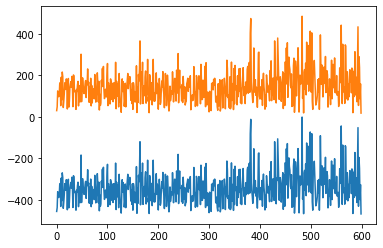

In [19]:
evaluate(model, env_test, 600)

In [20]:
hist = model.learn(total_timesteps=100, log_interval = 10)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10       |
|    fps              | 218      |
|    time_elapsed     | 0        |
|    total_timesteps  | 21       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.4      |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 256      |
|    time_elapsed     | 0        |
|    total_timesteps  | 48       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

In [21]:
print(hist.logger.output_formats)

In [22]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

Mean reward: 3.9316666666666666 Num episodes: 600


3.9316666666666666

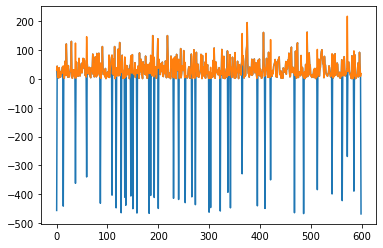

In [23]:
evaluate(model, env_test, 600)